In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import Transformer

In [2]:
nx = 500
test_x = torch.linspace(0, 10, nx).unsqueeze(-1)
test_y = torch.sin(test_x * 0.5) + torch.sin(test_x)

In [3]:
splts = [i * nx//5 for i in range(1, 6)]

In [4]:
train_x = torch.cat((test_x[:splts[0], :], 
                     test_x[splts[1]:splts[2], :], 
                     test_x[splts[3]:splts[4], :]))
train_y = torch.cat((test_y[:splts[0], :], 
                     test_y[splts[1]:splts[2], :], 
                     test_y[splts[3]:splts[4], :]))

In [5]:
optimus = Transformer(train_x, train_y, n_hidden=5, hidden_size=10,
                     activation=torch.nn.Tanh(), bias=True)

In [6]:
trained_pars = torch.load("../hess/saved-models/toy_regression2.pt", map_location="cpu")

In [7]:
optimus.net.load_state_dict(trained_pars)

<All keys matched successfully>

In [8]:
hessian = torch.load("../hess/saved-models/toy_hessian2.pt", map_location="cpu")

In [9]:
orig_pred = optimus(test_x)

In [10]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

### Perturb in largest e-vec basis

In [11]:
import hess.utils as utils

In [12]:
top_vecs = e_vec[:, 0:3]

In [13]:
n_pert = 10
scale = 0.05
pert_preds = torch.zeros(nx, n_pert)

In [14]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = top_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
#     print(perturb.shape)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

### Perturb in smallest e-vec basis

In [61]:
n_vec = 400
bot_vecs = e_vec[:, -n_vec:]

In [62]:
n_pert = 10
small_pert_preds = torch.zeros(nx, n_pert)

In [63]:
for jj in range(10):
    wghts = torch.randn(n_vec)
    perturb = bot_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb.shape)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
    small_pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])
torch.Size([1, 581])


### Plotting

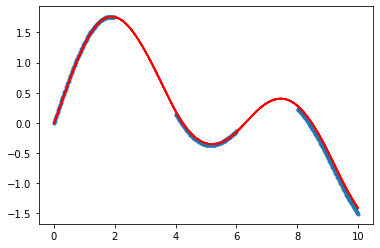

In [64]:
plt.scatter(train_x, train_y.detach(), marker=".")
plt.plot(test_x, small_pert_preds.detach(), color="red")

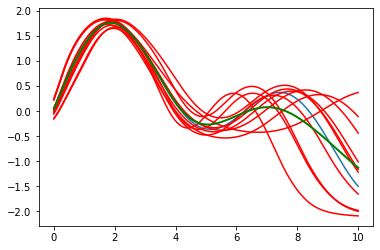

In [65]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, pert_preds.detach(), color="red")
plt.plot(test_x, pert_preds.mean(-1).detach(), color="green",
        linewidth=2.)

In [59]:
test = optimus(train_x)

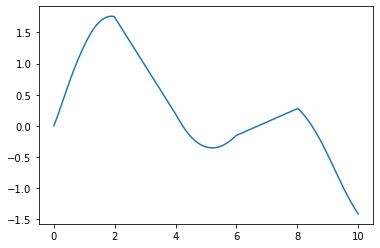

In [60]:
plt.plot(train_x, test.detach())

## Scratch

In [25]:
t1 = torch.randn(100, 1)
t2 = torch.randn(100, 1)

In [26]:
t1.squeeze().dot(t2.squeeze())

tensor(-5.7334)

In [27]:
t1.norm()

tensor(10.7496)

In [28]:
out = [p.data for p in optimus.net.parameters()]